In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.decomposition import KernelPCA

In [2]:
df = fetch_california_housing(as_frame=True)
# df.target gives the target values column
# df.frame["feature_name"] gives the feature_name column 

y = df.frame["MedHouseVal"]

df.frame = df.frame[(np.abs(stats.zscore(df.frame)) < 3).all(axis=1)] # remove outlayers

print(df.frame.shape)
print(df.frame)




(19794, 9)
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  MedHouseVa

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'MedHouseVal'}>]], dtype=object)

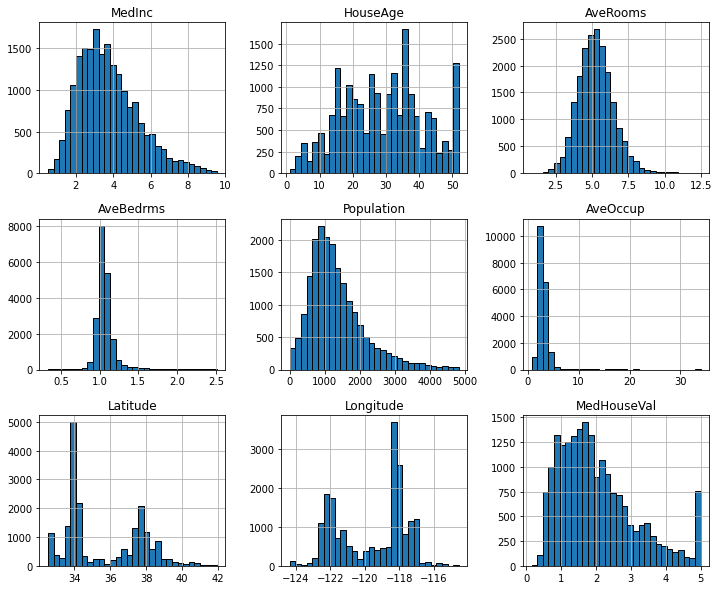

In [3]:
df.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")


Text(0.5, 1.0, 'Median house value depending of\n first 2 pca components')

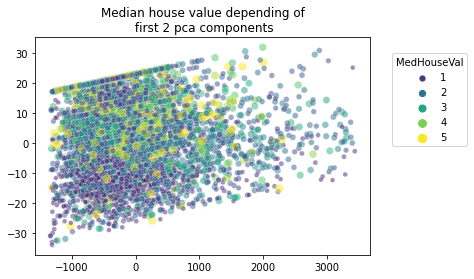

In [4]:
# PCA visualisation

pca = PCA()
Xt = pca.fit_transform(df.frame.drop(columns=["MedHouseVal"]))[:5000]


sns.scatterplot(data=Xt, x=Xt[:,0], y=Xt[:,1],
                size=df.target[:5000], hue=df.target[:5000],
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
plt.title("Median house value depending of\n first 2 pca components")


Text(0.5, 1.0, 'Median house value depending of\n first 2 pca components')

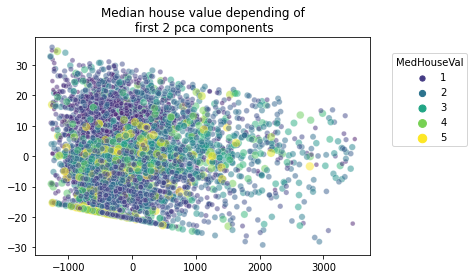

In [6]:
# kPCA visualisation with linear kernel
kpca = KernelPCA(n_components=2,kernel='linear')
Xt = kpca.fit_transform(df.frame[:5000])


sns.scatterplot(data=Xt, x=Xt[:,0], y=Xt[:,1],
                size=df.frame["MedHouseVal"][:5000], hue=df.frame["MedHouseVal"][:5000],
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
plt.title("Median house value depending of\n first 2 pca components")



Text(0.5, 1.0, 'Median house value depending of\n first 2 pca components')

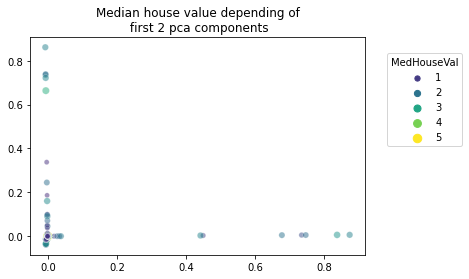

In [11]:
# kPCA visualisation with linear kernel
kpca = KernelPCA(n_components=2,kernel='rbf')
Xt = kpca.fit_transform(df.frame[:5000])


sns.scatterplot(data=Xt, x=Xt[:,0], y=Xt[:,1],
                size=df.frame["MedHouseVal"][:5000], hue=df.frame["MedHouseVal"][:5000],
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
plt.title("Median house value depending of\n first 2 pca components")


Text(0.5, 1.0, 'Median house value depending of\n their spatial location')

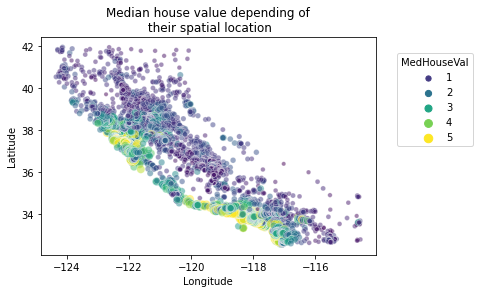

In [76]:
plt.subplots_adjust(hspace=0.7, wspace=0.4)

sns.scatterplot(data=df.frame, x="Longitude", y="Latitude",
                size="MedHouseVal", hue="MedHouseVal",
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
plt.title("Median house value depending of\n their spatial location")

AveOccup      -0.253569
Latitude      -0.144784
AveBedrms     -0.090918
Longitude     -0.046023
Population    -0.023932
HouseAge       0.112016
AveRooms       0.255413
MedInc         0.658217
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64


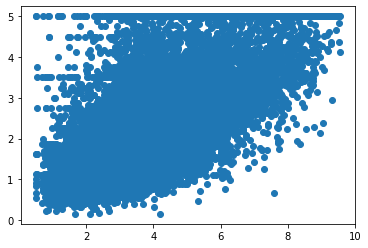

In [78]:
plt.scatter(df.frame["MedInc"],df.frame["MedHouseVal"])
corr_matrix = df.frame.corr()
print(corr_matrix["MedHouseVal"].sort_values())

In [81]:

print(df.frame)
# after scaling, cannot access with the scaled data with name of column feature

X_train, X_test, y_train, y_test = train_test_split(df.frame.drop(columns=["MedHouseVal"]), df.frame["MedHouseVal"], test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  MedHouseVal  
0      